# Case 3
Dan Suman<br>
Last edited: 03.03.2019<br>
Cognitive Systems for Health Technology Applications<br>
[Helsinki Metropolia University of Applied Sciences](http://www.metropolia.fi/en/)<br>

## 1. Objectives

The main focus for this notebook is to predict a drug rating based on the text review. 
The prediction will belong to one of five categories (highly negative, negative, 
neutral, positive, highly positive). For the prediction Recurrent Neural Network will 
be used.

## 2. Data processing

In [6]:
# Read basic libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("input"))

['drugsComTrain_raw.csv', 'drugsComTest_raw.csv']


In [7]:
# Read the training data
data = pd.read_csv('input/drugsComTrain_raw.csv')
test_data = pd.read_csv('input/drugsComTest_raw.csv')

In [8]:
# Show the head of the data
data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


Create the rating labels as stated in the notebook goals:

In [9]:
def rating_label(rating):
    if rating > 8:
        return 4
    elif rating > 6:
        return 3
    elif rating > 4:
        return 2
    elif rating > 2:
        return 1
    else:
        return 0
    
data['category'] = data.rating.apply(lambda x: rating_label(x))
test_data['category'] = test_data.rating.apply(lambda x: rating_label(x))

data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,category
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,4
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,3
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,2
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,3
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,4


In [10]:
# Check ratings to labels conversion
import matplotlib.pyplot as plt
data.plot(x = 'rating', y = 'category', kind = 'scatter')
plt.show()

<Figure size 640x480 with 1 Axes>

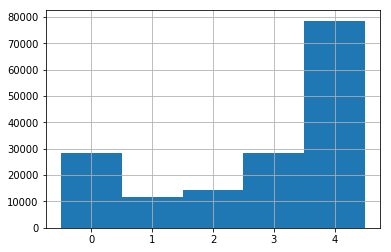

In [34]:
data['category'].hist(bins= np.arange(0,6), align='left')


The reviews contain a lot of text that can be normalized in order to produce better results. I will be using the nlp library spacy for pre-trained english model and nltk for stopwords. The function normalize will transform the text (lowercase, lemmatize and remove stopwords) from all the reviews.  

In [11]:
#download en model python -m spacy download en
#download python -m nltk.downloader all

import spacy #load spacy
import nltk
from nltk.corpus import stopwords

nlp = spacy.load("en_core_web_lg", disable=['parser', 'tagger', 'ner'])
stops = stopwords.words("english")

def normalize(comment, lowercase, remove_stopwords):
    if lowercase:
        comment = comment.lower()
    comment = nlp(comment)
    lemmatized = list()
    for word in comment:
        lemma = word.lemma_.strip()
        if lemma:
            if not remove_stopwords or (remove_stopwords and lemma not in stops):
                lemmatized.append(lemma)
    return " ".join(lemmatized)

data['new_review'] = data['review'].apply(normalize, lowercase=True, remove_stopwords=True)

data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,category,new_review
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,4,""" side effect , take combination bystolic 5 mg..."
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,3,""" son halfway 4 week intuniv . become concern ..."
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,2,""" use take another oral contraceptive , 21 pil..."
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,3,""" ﻿1 time use form birth control . i&#039;m gl..."
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,4,""" suboxone completely turn life around . feel ..."


In [12]:
test_data['new_review'] = test_data['review'].apply(normalize, lowercase=True, remove_stopwords=True)

test_data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,category,new_review
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22,4,""" i&#039;ve try antidepressant year ( citalopr..."
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17,3,""" son crohn&#039;s disease good asacol . compl..."
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3,4,""" quick reduction symptom """
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35,4,""" contrave combine drug use alcohol , smoke , ..."
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4,4,""" birth control one cycle . read review type s..."


In [14]:
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Read a part of the reviews and create training sequences (x_train)
samples = data['new_review'].iloc[:10000]
tokenizer = Tokenizer(num_words = 1000)
tokenizer.fit_on_texts(samples)
sequences = tokenizer.texts_to_sequences(samples)
x_train = pad_sequences(sequences, maxlen = 500)

test_samples = test_data['new_review'].iloc[:10000]
test_tokenizer = Tokenizer(num_words = 1000)
test_tokenizer.fit_on_texts(test_samples)
test_sequences = tokenizer.texts_to_sequences(test_samples)
x_test = pad_sequences(test_sequences, maxlen = 500)

In [15]:
from keras.utils import to_categorical

# Convert the labels to one_hot_category values
labels = data['category']
test_labels = test_data['category']
one_hot_labels = to_categorical(labels[:10000], num_classes = 5)
one_hot_test_labels = to_categorical(test_labels[:10000], num_classes = 5)

In [16]:
# Check the training and label sets
x_train.shape, one_hot_labels.shape

((10000, 500), (10000, 5))

## 3. Model compilation

In [24]:
# We use the same plotting commands several times, so create a function for that purpose
def plot_history(history):
    
    f, ax = plt.subplots(1, 2, figsize = (16, 7))
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.sca(ax[0])
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.sca(ax[1])
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()


In [25]:

from keras.layers import Dense, Embedding, Input, Activation, LSTM, Bidirectional, Dropout, GlobalMaxPooling1D
from keras.models import Sequential

model = Sequential()
model.add(Embedding(1000, 8, input_length = 500))
model.add(Bidirectional(LSTM(100, return_sequences=True, dropout=0.25, recurrent_dropout=0.1)))
model.add(GlobalMaxPooling1D())
model.add(Dense(50, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(5, activation='softmax'))
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500, 8)            8000      
_________________________________________________________________
bidirectional_4 (Bidirection (None, 500, 200)          87200     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 200)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                10050     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 255       
Total params: 105,505
Trainable params: 105,505
Non-trainable params: 0
_________________________________________________________________


## 4. Results

Train on 7500 samples, validate on 2500 samples
Epoch 1/50
7500/7500 [==============================] - 711s 95ms/step - loss: 1.3903 - acc: 0.4868 - val_loss: 1.3665 - val_acc: 0.4808

Epoch 00001: val_loss improved from inf to 1.36647, saving model to model.h5
Epoch 2/50
7500/7500 [==============================] - 657s 88ms/step - loss: 1.2793 - acc: 0.5108 - val_loss: 1.2517 - val_acc: 0.5216

Epoch 00002: val_loss improved from 1.36647 to 1.25173, saving model to model.h5
Epoch 3/50
7500/7500 [==============================] - 645s 86ms/step - loss: 1.1798 - acc: 0.5599 - val_loss: 1.2279 - val_acc: 0.5268

Epoch 00003: val_loss improved from 1.25173 to 1.22787, saving model to model.h5
Epoch 4/50
7500/7500 [==============================] - 663s 88ms/step - loss: 1.1388 - acc: 0.5763 - val_loss: 1.2153 - val_acc: 0.5304

Epoch 00004: val_loss improved from 1.22787 to 1.21532, saving model to model.h5
Epoch 5/50
7500/7500 [==============================] - 665s 89ms/step - loss: 1

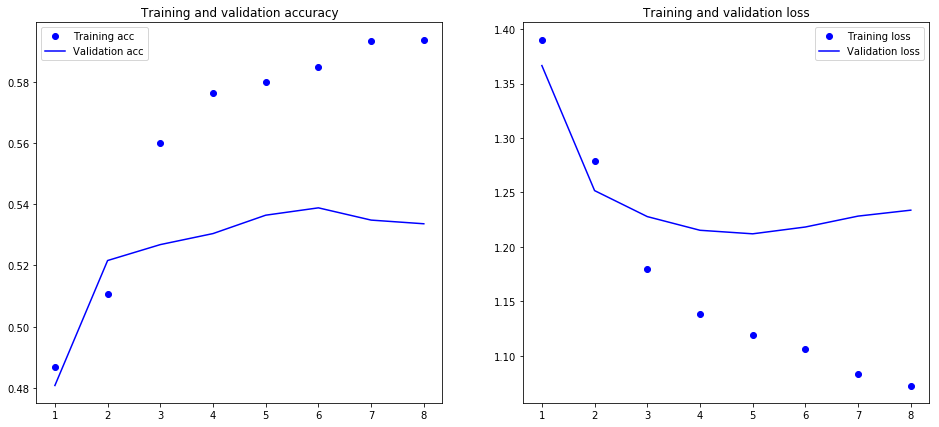

In [26]:
# Train the first model and plot the history
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

checkpoint = ModelCheckpoint("model.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor='val_loss', mode='min', patience=3)
callback = [checkpoint, early]

history = model.fit(x_train, one_hot_labels, epochs = 50, batch_size = 32, verbose = 1, validation_split = 0.25, callbacks = callback)
plot_history(history)

In [30]:
# load weights into new model
model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
score = model.evaluate(x_test, one_hot_test_labels, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))



Loaded model from disk
10000/10000 [==============================] - 152s 15ms/step
acc: 56.12%


## 5. Conclusion

Based on multiple tryouts an important step in sentiment prediction is the text processing. More extensive processing can be done than the normalizer introduced in step 2. Regarding the model evaluation, best accuracy was achieved using a bidirectional LSTM layer (a solutiong for the vanishing gradient problem) and 2 dense layers. An accuracy of 56.12% was achieved using the model with the best weights. To further increase this performance a further enhacement will be to use a pretrained existing model like Glove (https://nlp.stanford.edu/projects/glove/). 